# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no
    changed in October by Thomas Bellotti

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [17]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [18]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [19]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 10204 / 11441 MB available


In [20]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel (float * c, float * a, float * b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    // Do...
    // c[j][i] = a[j][i] + b[j][i]
    unsigned int k = j*cols + i;
    c[k] = a[k] + b[k];
}
// Note: we have to implement the function matrixVectorKernel
// c = A*b
__global__ void addMatrixVectorKernel (float * c, float * A, float * b, int a_rows, int a_cols)
{
 // .... a for loop computing a vector-vector inner produc
 
 /* My solution was quite correct except for the use of c instead of a local variable
 
     unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;

     c[i] = 0;

     for (int j = 0; j < a_cols; ++i)
     {     
         unsigned int k = j + i;
         c[i]+=a[k]*b[j]; 
     }
     
     // SOlution
     */
     
     
     unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
     float sum = 0.0f; // The f is important, since double are expensive
     
     for (int i = 0; i < a_cols; ++i){
         unsigned int k = j*a_cols + i;
         sum += A[k]*b[i];
     }
     
     c[j] = sum;
     
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
#kernel = module.get_function("addMatrixKernel");
kernel = module.get_function("addMatrixVectorKernel");

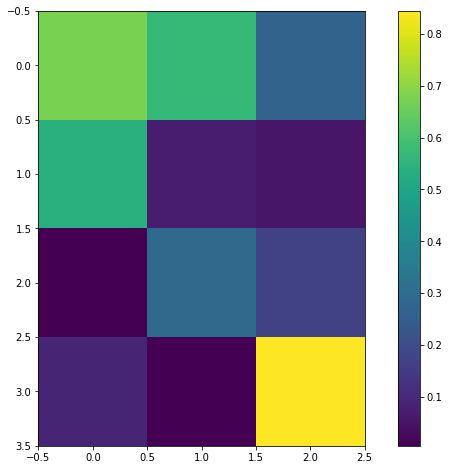

In [21]:
#Size of our test
test_size = (16,24)


#Create test input / output data
a = np.random.random((4,3)).astype(np.float32)
b = np.random.random((3,1)).astype(np.float32)
c = np.empty((4,1))

fig = plt.figure(figsize = (12,8))
plt.imshow(a)
plt.colorbar()
plt.show()



In [7]:
print(a.shape)

(16, 24)


In [8]:
#Upload data to the device
#Note: we have to make sure that a = (rows, colums) and that b = (columns in A, 1) (column vector)
# and that c = (rows in A, 1)
a_shape = a.shape
print(a_shape)

(16, 24)


In [22]:
a_g = GPUArray(a_shape, np.float32)
b_g = GPUArray(a_shape, np.float32)
a_g.set(a)
b_g.set(b)

ValueError: ary and self must be the same size

In [10]:
#Allocate output data
c_g = GPUArray(a_shape[0], np.float32)

In [14]:
# a.shape =  (rows, columns) --> [y,x]
domain_size = (a.shape[0],a.shape[1]) # Now domain size is [x,y]

# NOte that we need to change this in order to be x = 1 and y = #of rows in A

block_size = (1,1,1) # This needs to be [x,y,z]
grid_size = (domain_size[0] // block_size[0], 1, 1) # // is the integer division in modern python
print("Block size = " + str(block_size))
print("Grid size = " + str (grid_size))
print("Domain size = " + str(domain_size))

Block size = (1, 1, 1)
Grid size = (16, 1, 1)
Domain size = (16, 24)


In [16]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[1]), np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([2.63217, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     ], dtype=float32)

In [43]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [3.4516053 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.       ]
Ref =  [[1.1085651  1.4991238  0.79989314 1.4544232  0.48324126 0.93999213
  1.1217567  0.4726387  1.4081647  1.0956933  0.41127402 1.2377403
  0.7128626  0.41596764 1.0291266  1.2289723  1.1958678  1.6720377
  1.0418696  0.3290859  0.27561504 1.1961894  0.9377856  0.7672279 ]
 [1.1795946  0.78494954 1.0294585  0.97696495 0.6443581  0.81723034
  0.99044687 0.9615631  0.56221694 0.32306418 1.1221373  1.9552861
  0.57946175 0.34487852 0.8186468  0.7130165  1.7540631  0.9598453
  1.8095504  1.0730743  0.5107528  1.5756875  0.22641379 1.1913673 ]
 [1.4126525  0.9659933  0.80843234 1.80986    0.31497496 0.2924969
  1.5099473  0.48850346 0.72227347 1.1935116  0.7167786  1.5600047
  0.87050045 0.86112815 1.8017364  1.549468   0.8739138  1.085296
  1.4976192  0.9504899  0.90847564 1.2169344  0.5324544  0.8433567 ]
 [0.5820235  1.1176183  0

ValueError: operands could not be broadcast together with shapes (16,) (16,24) 

TypeError: Invalid dimensions for image data

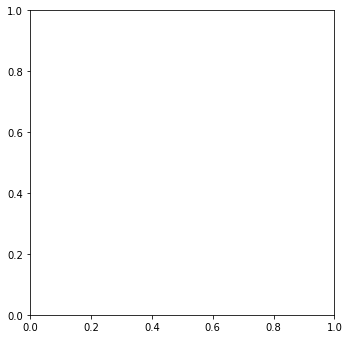

In [44]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)